A2.1_588359

DIEGO MARCELO GONZALEZ LUJAN IMT 588359

1. La base de datos fue obtenida de la página oficial del INEGI, la base se llama Encuesta Anual de Empresas Constructoras (EAEC) Serie 2018. Esta encuesta tiene como objetivo generar estadísticas sobre la estructura y el comportamiento económico del sector construcción en México, sirviendo como insumo para cálculos macroeconómicos y diversos indicadores. Se basa en estándares internacionales y normativas nacionales, centrándose en el sector 23 Construcción según el Sistema de Clasificación Industrial de América del Norte (SCIAN) 2018.

La unidad de observación es la empresa constructora, y se recopila información sobre vinculación internacional, empleo, remuneraciones, horas trabajadas, gastos, ingresos, valor de producción, activos fijos, construcción de vivienda y otras características empresariales. La cobertura es nacional con desgloses por entidad federativa y la periodicidad es anual.

El diseño estadístico utiliza el Registro Estadístico de Negocios de México (RENEM) como marco de muestreo, con un esquema probabilístico y estratificado. Se consideran niveles de confianza del 95%, tasas de no respuesta entre 15% y 26%, y coeficientes de variación de 6% a 11%. Las variables clave son el personal ocupado total y el valor de producción.


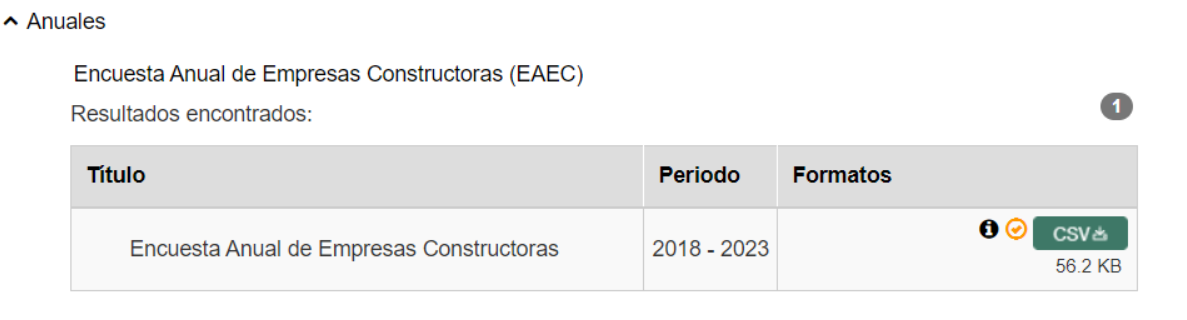




In [10]:
import pandas as pd

df = pd.read_csv('tr_eaec_nac_ent_absoluto_2018_2023.csv')

print(df.head())

# Crear una variable binaria a partir de la columna 'ESTATUS'
df['BINARIA'] = df['ESTATUS'].apply(lambda x: 1 if x == 'Cifras definitivas' else 0)

print(df[['ESTATUS', 'BINARIA']].head())

   CODIGO_ACTIVIDAD                         DESCRIPCION_ACTIVIDAD  ANIO  \
0                23                                  Construcción  2018   
1               236                                   Edificación  2018   
2               237     Construcción de obras de ingeniería civil  2018   
3               238  Trabajos especializados para la construcción  2018   
4                23                                  Construcción  2018   

   CODIGO_ENTIDAD         ENTIDAD  H000B_Y_H000C_I000B_Y_I000C  H000B_Y_I000B  \
0               0        Nacional                       643177         547622   
1               0        Nacional                       320296         270733   
2               0        Nacional                       194162         169260   
3               0        Nacional                       128719         107629   
4               1  Aguascalientes                        10827           9275   

   H000C_Y_I000C  H000A_H000B_Y_H000C   H000B  ...    Q300C   

2. El codigo divide la base de datos en entrenamiento de 80% y un conjunto de pruebas en 20%, asegurando que la proporcion de clases en la variable binaria se mantenga constante en ambas particiones gracias al vcodigo stratigy = y. Al calcular las proporciones en el conjunto original obtuve un 83,33% de las observaciones pertenece a la calse 1 y el 16.67% a la clase 0, lo que esot muestra un desbalance en los datos. En el conjunto de entrenamiento las proporciones se mantienen similares 83.14% y 16.86%, mientras que en el conjunto de prueba hay una pequeña variacion, con 84,09% de la clase 1  y 15.91% en la clase 0, lo cual es normal debido a la seleccion aleatoria. 

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ESTATUS', 'BINARIA'])
y = df['BINARIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Proporciones en el conjunto original:")
print(y.value_counts(normalize=True))

print(f"\nProporciones en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print(f"\nProporciones en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))



Proporciones en el conjunto original:
BINARIA
1    0.833333
0    0.166667
Name: proportion, dtype: float64

Proporciones en el conjunto de entrenamiento:
BINARIA
1    0.831395
0    0.168605
Name: proportion, dtype: float64

Proporciones en el conjunto de prueba:
BINARIA
1    0.840909
0    0.159091
Name: proportion, dtype: float64


3. El codigo tiene un modelo de regresion logisitca para clasificar al variable binaria, seleccionando las 5 caracteristicas que son mas relevantes mediante la prueba ANOVA (f_classif). Lo que hice primero es eliminar las columnas ESTATUS y BINARIA de df y almacenar las variables objetivo en la Y. Como el modelo es de regresion logistica solo trabaja con datos NUMERICOS, para esto utilize la libreria LabelEncoder para convertir todas las variables categoricas en valores NUMERICOS. Luego use SelectKBest con f_classif lo cual selecciona las 5 mas importantes para la clasificacion. Al final entrene un modelo de regresion logistica con max_iter=1000 y se evalua con validacion cruzada de 5 iteraciones usando el codigo accuracy como metrica.

Los resultados se vieron que la exactitud del modelo varia en cada fol de validazion cruzada, con valores entre 25.58% y 90.69% lo que esto indica una alta variabilidad segun el conjunto de entrenamiento y de prueba de cada iteracion. La exactitud promedio es de 74.94% lo que significa que el modelo tiene un rendimiento moderado, aunque la baja precision en un fold especifico podria indicar problemas de especifico podria indicar problemas de desbalance en los datos. 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

X = df.drop(columns=['ESTATUS', 'BINARIA']) 
y = df['BINARIA']

#Convertir todas las columnas no numéricas a numéricas usando LabelEncoder
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

#Seleccion de 5 caracteristicas
selector = SelectKBest(f_classif, k=5)
X_selected = selector.fit_transform(X, y)

#Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')

print(f"Scores de validación cruzada (exactitud) en cada fold: {cv_scores}")
print(f"Exactitud media: {np.mean(cv_scores)}")


Scores de validación cruzada (exactitud) en cada fold: [0.88636364 0.90697674 0.86046512 0.8372093  0.25581395]
Exactitud media: 0.7493657505285413


4. el codigo entrena un modelo de regreso logistica y evalua un desempeño con tres umbrales de decision (0.5,0.3,0.7). Se usa el codigo de predict_proba para obtener la probabilidad y calsificar segun cada umbral. Luego, se calculan exactitud, sensibilidad y especificidad.

Los resultados muestran que el umbral 0.5 la exactitud es de 77.27%, con una alta sensibilidad de 86.49% pero algunos falsos positivos. Con umbral 0.7 la sesibilidad baja a 81.08% pero la especificidad sube hasta 90.91%, reduciendo falsos positivos. Con umbral 0.3, la esactitud sube a 81.82% con una sensibilidad 01.89% pero mas falsos positivos. 

En resumen cuando el umbral baja aumenta la sensibilidad, lo cual detecta msa positivos, pero mas falsos positivos, mientras que subirlo mejora la precision de los positivos. 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamos el modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1] 

umbral_1 = 0.5
umbral_2 = 0.7
umbral_3 = 0.3

def calcular_metricas(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Exactitud, Sensibilidad y Especificidad
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  
    specificity = precision_score(y_true, y_pred)  
    
    return accuracy, sensitivity, specificity, cm

#Umbral 0.5
y_pred_1 = (y_prob >= umbral_1).astype(int)
accuracy_1, sensitivity_1, specificity_1, cm_1 = calcular_metricas(y_test, y_pred_1)

#Umbral 0.7
y_pred_2 = (y_prob >= umbral_2).astype(int)
accuracy_2, sensitivity_2, specificity_2, cm_2 = calcular_metricas(y_test, y_pred_2)

#Umbral 0.3
y_pred_3 = (y_prob >= umbral_3).astype(int)
accuracy_3, sensitivity_3, specificity_3, cm_3 = calcular_metricas(y_test, y_pred_3)

print(f"Umbral 0.5:")
print(f"Exactitud: {accuracy_1:.4f}, Sensibilidad: {sensitivity_1:.4f}, Especificidad: {specificity_1:.4f}")
print(f"Matriz de Confusión:\n{cm_1}")

print(f"\nUmbral 0.7:")
print(f"Exactitud: {accuracy_2:.4f}, Sensibilidad: {sensitivity_2:.4f}, Especificidad: {specificity_2:.4f}")
print(f"Matriz de Confusión:\n{cm_2}")

print(f"\nUmbral 0.3:")
print(f"Exactitud: {accuracy_3:.4f}, Sensibilidad: {sensitivity_3:.4f}, Especificidad: {specificity_3:.4f}")
print(f"Matriz de Confusión:\n{cm_3}")

/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Umbral 0.5:
Exactitud: 0.7727, Sensibilidad: 0.8649, Especificidad: 0.8649
Matriz de Confusión:
[[ 2  5]
 [ 5 32]]

Umbral 0.7:
Exactitud: 0.7727, Sensibilidad: 0.8108, Especificidad: 0.9091
Matriz de Confusión:
[[ 4  3]
 [ 7 30]]

Umbral 0.3:
Exactitud: 0.8182, Sensibilidad: 0.9189, Especificidad: 0.8718
Matriz de Confusión:
[[ 2  5]
 [ 3 34]]


5. En este codigo hice muestra la Curva ROC de mi modelo de regresion logistica, con una AUC de 0.8185. Esto significa que tiene un buen desempeño en la calsificacion ya que el valor esta por encima de 0.5(clasificacion aleatoria). Cuanto mas cerca de 1, mejor el modelo en distinguir entre clases positivas y negativas.


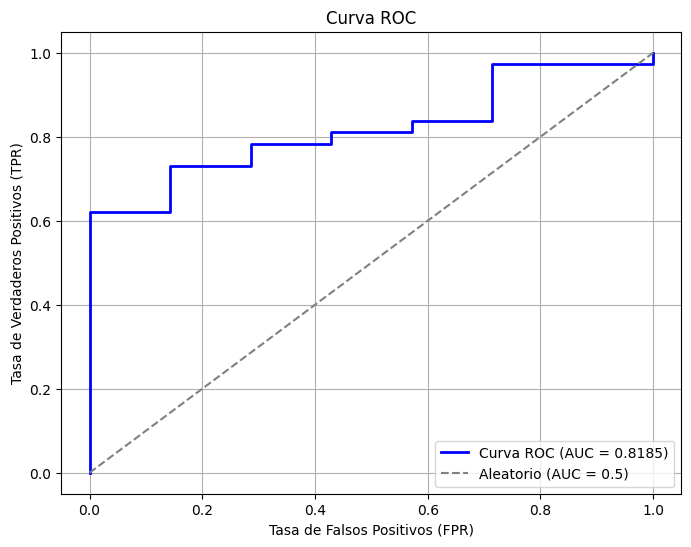

El valor del AUC es: 0.8185


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el AUC
auc_value = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_value:.4f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio (AUC = 0.5)')  
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"El valor del AUC es: {auc_value:.4f}")


6. Por ultimo extraje los ceoficientes y los asocie con las caracteristicas del conjunto de datos. Luego calcule los odds ratio para intepretar el impacto de cada variiable en la probabilidad de la clasificacion. Un odds ratio de > 1 significa un efecto negativo. Los coeficientes mas altos o mas bajos reflejan las variables con mayor inlfuencia en la prediccion. 

In [17]:
# Obtener coeficientes y nombres de características
coeficientes = model.coef_[0]
caracteristicas = X_train.columns

# Crear un DataFrame con los coeficientes y los odds ratios
resultados = pd.DataFrame({
    'Variable': caracteristicas,
    'Coeficiente': coeficientes,
    'Odds Ratio': np.exp(coeficientes)
})

# Ordenar por magnitud de impacto
resultados = resultados.sort_values(by='Coeficiente', ascending=False)

print(resultados)

   Variable  Coeficiente  Odds Ratio
48    M590A     0.000020    1.000020
33    K200A     0.000015    1.000015
66    Q000C     0.000013    1.000013
38    K610A     0.000011    1.000011
69    Q300C     0.000010    1.000010
..      ...          ...         ...
56    Q200A    -0.000004    0.999996
61    Q100B    -0.000007    0.999993
34    K421A    -0.000008    0.999992
47    M510A    -0.000012    0.999988
37    K590A    -0.000020    0.999980

[78 rows x 3 columns]
